## Analysis Notebook 3: Single Trajectory Viewing 

after running batch analysis, you can come to this notebook if you see trajectories of interest that you want to analyze further/recreate figures. the only input you need is a folder of CSVs.

In [1]:
import pandas as pd 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.widgets import Slider, Button
from matplotlib.patches import Circle
from matplotlib.animation import FuncAnimation
from scipy.stats import norm, gaussian_kde
from tweezepy import PSD
import seaborn as sns
import math
import ipympl
import csv
import sys
import os

In [5]:
# PATH SETTINGS ##########
# load your trajectory into file_path, must be directly to an existing csv file
csv_number = '00001'
analysis_date = '240123'
file_path = '/Users/laurentakiguchi/Desktop/DNAntenna-Code/data/20230721_antenna/antenna50nick/ib30g/638_1000hz_0001trcsv/' + csv_number + '.csv' 
exp_name = file_path.split('/')[-2]
save_figs = 1 # 1 = saves plots to folder, 0 = doesn't save plots
save_folder = '/Users/laurentakiguchi/Desktop/' # where your plots will save
os.makedirs(save_folder,exist_ok=True)

# ACQUISITION SETTINGS ############
pixel_size = 108 # camera specific, 1 pixel = pixel_size nm
fsample = 1000 # in Hz or s^-1, acquisition framerate 
###################################

print('title as:',csv_number) # plot title and save handles, make sure it's right

title as: 00001


In [6]:
# data_raw: raw data dataframe, data_crop: cropped data dataframe
# returns xx (pos in pixels), yy (pos in pixels), c0int (integrated intensity), fitheight (height of gaussian), noise (bckg noise), SNR (fitheight/noise)
data_raw = pd.read_csv(file_path,names=['xx','yy','c0int','fitheight','noise','SNR'])
data_raw = data_raw[(data_raw['xx'] != 0) & (data_raw['yy'] != 0)] # drop zero values from dataframe
data_raw['xpos_nm'] = data_raw['xx']*pixel_size
data_raw['ypos_nm'] = data_raw['yy']*pixel_size
data_crop = data_raw.head(-100) # how many frames to crop dataframe by from end (head(10) removes last 10 frames)

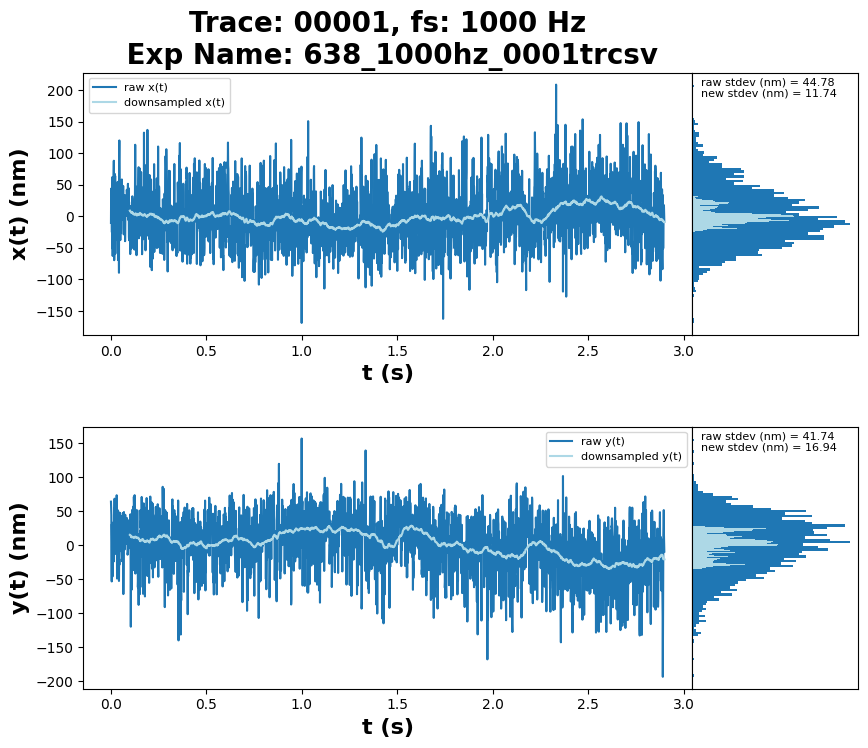

In [22]:
# 1D RAW DATA W/ DOWNSAMPLED OVERLAY PLOT ########
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 8), ncols=2, nrows=2, gridspec_kw={'width_ratios': [2.75, .75], 'hspace': 0.35, 'wspace': 0})

x_com, y_com = data_crop['xpos_nm'].mean(), data_crop['ypos_nm'].mean() # centers peak on center of mass
dx, dy = data_crop['xpos_nm'] - x_com, data_crop['ypos_nm'] - y_com
N = len(data_crop['xpos_nm'])
time = np.arange(N) / fsample
# t_data_crop: cropped data centered relative to center of mass
t_data_crop = pd.DataFrame({'xpos_nm': data_crop['xpos_nm'], 'ypos_nm': data_crop['ypos_nm'], 'xpos_nm_t': dx, 'ypos_nm_t': dy,
                           'c0int': data_crop['c0int'], 'fitheight': data_crop['fitheight'], 'noise': data_crop['noise'], 'SNR': data_crop['SNR']})

for i in range(2): # plots x(t), y(t) at fsample
    ax[i, 0].plot(time, t_data_crop[f'{["xpos_nm_t", "ypos_nm_t"][i]}'], label=f'raw {["x(t)", "y(t)"][i]}')
    ax[i, 0].set_xlabel('t (s)', fontsize=16, fontweight='bold')
    ax[i, 0].set_ylabel(f'{["x(t) (nm)", "y(t) (nm)"][i]}', fontsize=16, fontweight='bold')
    ax[i, 0].legend(fontsize=8)

    hist = ax[i, 1].hist([dx, dy][i], bins=100, orientation='horizontal')
    ax[i, 1].set_xticks([])
    ax[i, 1].set_yticks([])
    std_val = np.std([t_data_crop['xpos_nm_t'], t_data_crop['ypos_nm_t']][i])
    ax[i, 1].annotate("raw stdev (nm) = {:.2f}".format(std_val), xy=(0.05, 0.98), xycoords='axes fraction', ha='left', va='top', fontsize=8)

# overlays downsampled trace at a frequency of choice
new_fsample = 10 # Hz
downsample_factor = int(fsample/new_fsample) # number of points to average in each window
downsampled_data = pd.DataFrame({
    'x': t_data_crop['xpos_nm_t'].rolling(window=downsample_factor).mean(),
    'y': t_data_crop['ypos_nm_t'].rolling(window=downsample_factor).mean()})
downsampled_time = np.linspace(0, len(t_data_crop)/fsample, len(downsampled_data['x']))

for i in range(2): # plots downsampled x(t), y(t) at new_fsample
    ax[i, 0].plot(downsampled_time, downsampled_data[['x', 'y'][i]], label=f'downsampled {["x(t)", "y(t)"][i]}', color='lightblue')
    hist = ax[i, 1].hist(downsampled_data[['x', 'y'][i]], bins=100, color='lightblue', orientation='horizontal')
    std_downsample = np.std([downsampled_data['x'], downsampled_data['y']][i])
    ax[i, 1].annotate('new stdev (nm) = {:.2f}'.format(std_downsample), xy=(0.05, 0.94), xycoords='axes fraction', ha='left', va='top', fontsize=8)

ax[0, 0].legend(fontsize=8)
ax[1, 0].legend(fontsize=8)
ax[0, 0].set_title(f'Trace: {csv_number}, fs: {fsample} Hz\n Exp Name: {exp_name}', fontsize=20, fontweight='bold')
plt.show()

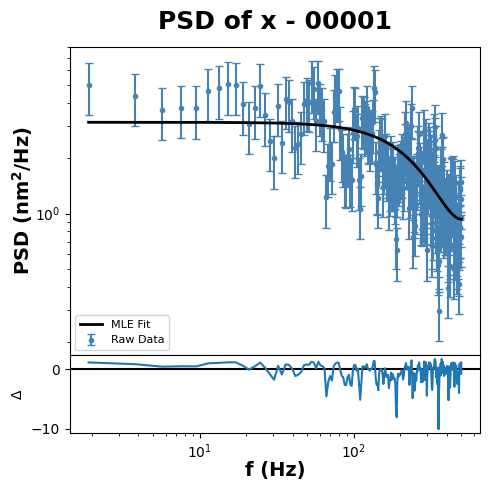

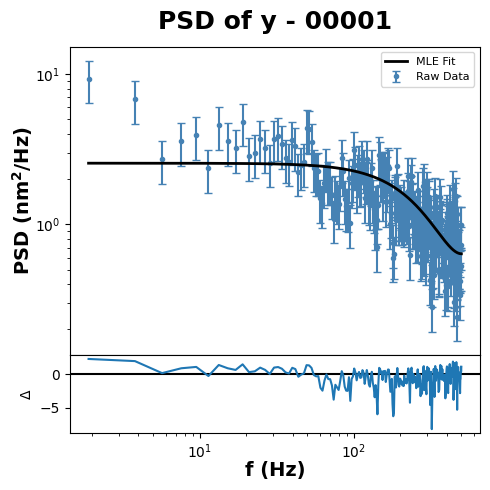

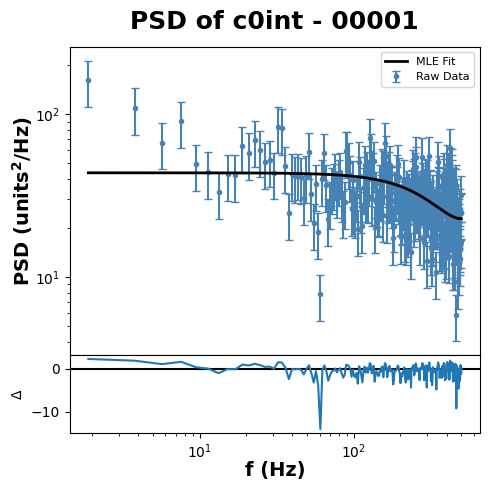

In [23]:
# 3x PSD (POWER SPECTRAL DENSITY) W/ FITTED LORENTZIAN PLOTS ###########
%matplotlib inline
binsize = 10 # can change this

#t_data_crop.dropna(inplace=True)
psdtrace_x = t_data_crop['xpos_nm_t']
psdtrace_y = t_data_crop['ypos_nm_t']
psdtrace_c0int = t_data_crop['c0int']
N_psd = len(psdtrace_x) # num points in trajectory
psdtrace_time = np.arange(N)/fsample # in s

psd_x = PSD(psdtrace_x,fsample,bins=binsize)
psd_y = PSD(psdtrace_y,fsample,bins=binsize)
psd_c0int = PSD(psdtrace_c0int,fsample,bins=binsize)
psd_x.mlefit()
psd_y.mlefit()
psd_c0int.mlefit()

fig,ax = psd_x.plot(data_label='Raw Data', fit_label='MLE Fit', data_color='steelblue')
ax[1].set_xlabel('f (Hz)', fontsize=14,fontweight='bold',labelpad=0.01)
ax[0].set_ylabel(r'PSD ($\mathbf{nm^2/{Hz}}$)', fontsize=14,fontweight='bold',labelpad=0.01)
ax[0].set_title('PSD of x - '+csv_number,fontsize=18,fontweight='bold',y=1.03)
ax[0].legend(fontsize=8)
fig.set_size_inches(5,5)
plt.tight_layout()
plt.show()

fig,ax = psd_y.plot(data_label='Raw Data', fit_label='MLE Fit', data_color='steelblue')
ax[1].set_xlabel('f (Hz)', fontsize=14,fontweight='bold',labelpad=0.01)
ax[0].set_ylabel(r'PSD ($\mathbf{nm^2/{Hz}}$)', fontsize=14,fontweight='bold',labelpad=0.01)
ax[0].set_title('PSD of y - '+csv_number,fontsize=18,fontweight='bold',y=1.03)
ax[0].legend(fontsize=8)
fig.set_size_inches(5,5)
plt.tight_layout()
plt.show()

fig,ax = psd_c0int.plot(data_label='Raw Data', fit_label='MLE Fit', data_color='steelblue')
ax[1].set_xlabel('f (Hz)', fontsize=14,fontweight='bold',labelpad=0.01)
ax[0].set_ylabel(r'PSD ($\mathbf{units^2/{Hz}}$)', fontsize=14,fontweight='bold',labelpad=0.01)
ax[0].set_title('PSD of c0int - '+csv_number,fontsize=18,fontweight='bold',y=1.03)
ax[0].legend(fontsize=8)
fig.set_size_inches(5,5)
plt.tight_layout()
plt.show()

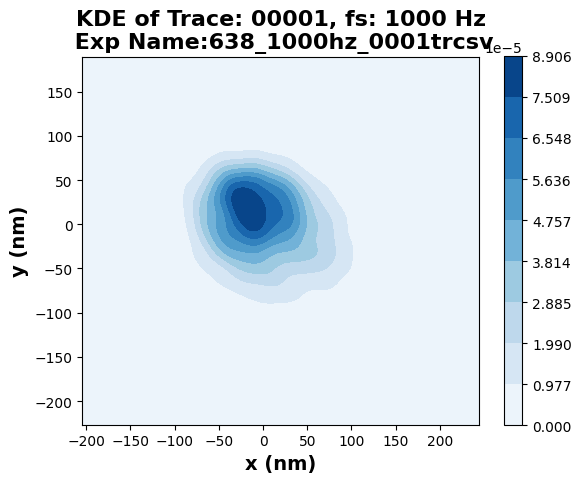

In [24]:
# 2D GAUSSIAN KDE PLOT ###########
%matplotlib inline
fig, ax = plt.subplots()
data = t_data_crop
x_kde = t_data_crop['xpos_nm_t']
y_kde = t_data_crop['ypos_nm_t']
kde = sns.kdeplot(data=data, x=x_kde, y=y_kde, cmap='Blues', fill=True, thresh=0, cbar=True)
    
ax.set_xlabel('x (nm)',fontsize=14,fontweight='bold')
ax.set_ylabel('y (nm)',fontsize=14,fontweight='bold')
ax.set_aspect('equal')
plt.title('KDE of Trace: '+csv_number+', fs: '+str(fsample)+' Hz\n Exp Name:'+exp_name, fontweight='bold', fontsize=16) 
plt.show()

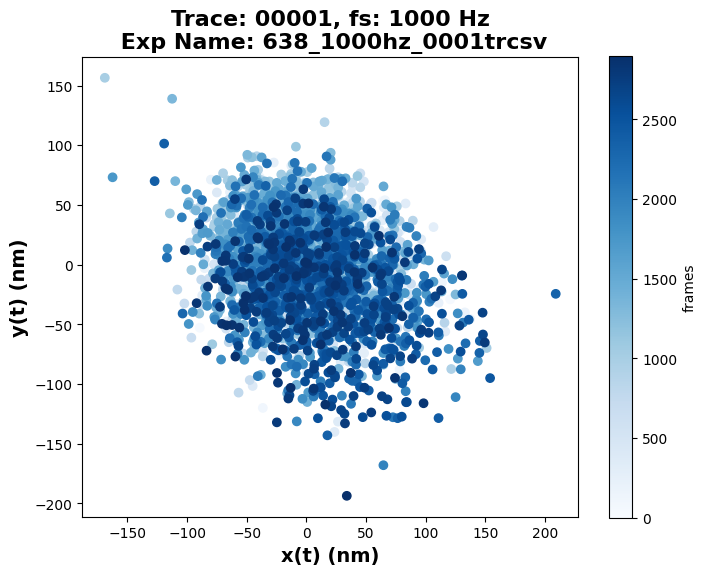

In [25]:
# 2D SCATTER PLOT ##########
%matplotlib inline
fig,ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(t_data_crop['xpos_nm_t'], t_data_crop['ypos_nm_t'], c=np.arange(len(t_data_crop)),cmap='Blues')
ax.set_xlabel('x(t) (nm)',fontweight='bold',fontsize=14)
ax.set_ylabel('y(t) (nm)',fontweight='bold',fontsize=14)
ax.set_aspect('equal')
ax.set_title(f'Trace: {csv_number}, fs: {fsample} Hz\n Exp Name: {exp_name}', fontsize=16, fontweight='bold')
plt.colorbar(scatter,ax=ax,label='frames')
plt.show()

In [10]:
# COORDINATE TRANSFORMATION #############
t_data_crop['r'] = np.sqrt(t_data_crop['xpos_nm_t']**2 + t_data_crop['ypos_nm_t']**2) # nm
t_data_crop['theta_rad'] = np.arctan2(t_data_crop['ypos_nm_t'],t_data_crop['xpos_nm_t']) # radians
t_data_crop

,xpos_nm,ypos_nm,xpos_nm_t,ypos_nm_t,c0int,fitheight,noise,SNR,r,theta_rad
0,31244.527222,12499.635498,15.137127,-12.138657,1845.0,159.090012,15.942633,9.978905,19.403082,-0.675906
1,31239.850342,12506.977936,10.460247,-4.796220,1575.0,158.282913,15.256166,10.375012,11.507410,-0.429916
2,31217.138306,12492.504822,-12.251789,-19.269334,1912.0,144.550720,15.231938,9.489975,22.834482,-2.137137
3,31233.828735,12520.610596,4.438640,8.836440,1675.0,157.746246,13.151703,11.994359,9.888590,1.105302
4,31217.451416,12510.846497,-11.938679,-0.927659,1995.0,173.573227,14.920964,11.632843,11.974665,-3.064047
...,...,...,...,...,...,...,...,...,...,...
1895,31246.086182,12510.684174,16.696086,-1.089982,1910.0,159.611481,14.910367,10.704732,16.731628,-0.065191
1896,31215.763916,12492.925049,-13.626179,-18.849107,1767.0,157.390533,12.828538,12.268782,23.258581,-2.196732
1897,31206.215698,12533.704376,-23.174397,21.930221,2068.0,172.861755,20.073008,8.611651,31.905913,2.383772
1898,31232.342285,12498.897217,2.952190,-12.876939,1872.0,171.710449,17.001383,10.099792,13.211017,-1.345429


<IPython.core.display.Javascript object>


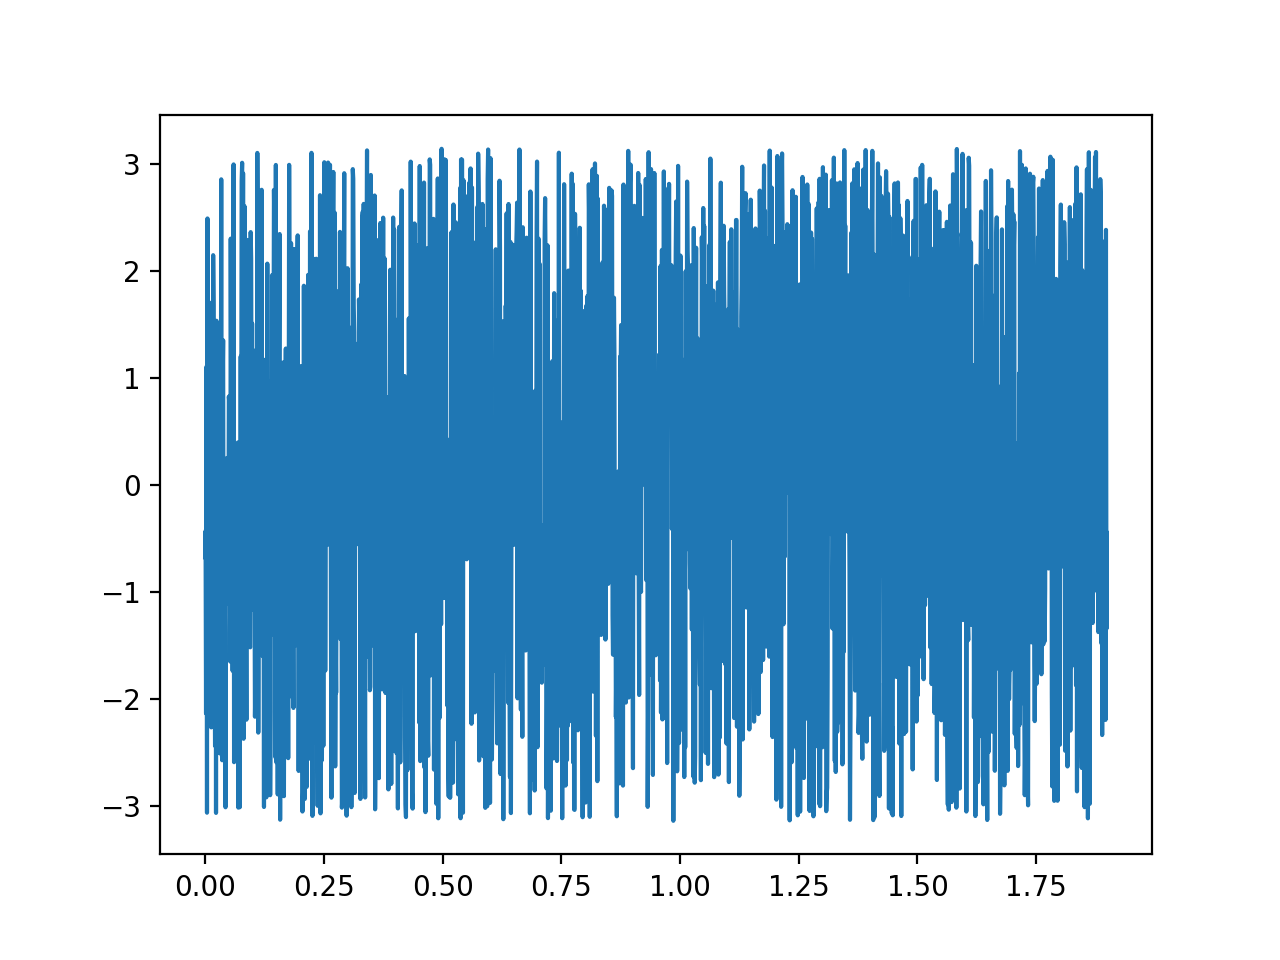

In [11]:
# PHI IS THE DNA BENDING ANGLE ##########
t_data_crop['phi_rad'] = t_data_crop['']
fig, ax = plt.subplots()
ax.plot(time,t_data_crop['theta_rad'])

## Integration Time Figure

In [ ]:
# frequency-indepedent contribution of photon-limited localization uncertainty -> sigma of localizations
def sigma_localizations(mu_intensity): # input: mean intensity of trajectory
    sigma_loc_error = (981.1868/np.sqrt(mu_intensity)) - 6.2673 # in nm, equation coefficients determined by bead fit
    return sigma_loc_error

intensity_mean = np.mean(t_data_crop['c0int'])
sigma_localizations_nm = sigma_localizations(intensity_mean) # in nm
sigma_localizations_angular = np.rad2deg(np.arcsin(sigma_localizations_nm / (85+8.67))) # in degrees
epsilon = (2*(sigma_localizations_angular**2))/fsample # frequency-independent localization uncertainty constant

print('Sigma Localizations (deg):', sigma_localizations_angular)
print('Epsilon:', epsilon)

In [ ]:
# theoretical sigma of θ (brownian motion only)

def sigma_brownian_theoretical(t): # input: time vector
    sigma_theoretical_brownian = np.sqrt(
        (2*kbT/kappa_axial)* # constant factor
        (tau_axial/t - (tau_axial**2/t**2)* # time dependent factor
        (1-np.exp(-t/tau_axial)))) # exponential decay factor

    return sigma_theoretical_brownian

# theoretical sigma of θ (brownian motion + localization uncertainty)

def sigma_brownian_loc_theoretical(t, sigma_loc): # input: time vector, sigma of localizations
    sigma_theoretical_brownian_loc = np.sqrt(
        (2*kbT/kappa_axial)* # constant factor
        (tau_axial/t - (tau_axial**2/t**2)* # time dependent factor
        (1-np.exp(-t/tau_axial)))+ # exponential decay factor
        sigma_loc**2/(fsample*t)) # localization uncertainty factor

    return sigma_theoretical_brownian_loc

In [ ]:
# calculates theoretical sigma of θ in 2 cases

integration_times_brownian = np.linspace(0.0005, 1, 10000) # in s
integration_times_brownian_loc = np.linspace(0.001, 1, 10000) # in s

integration_times_brownian_list = [] # initializes lists
sigma_theoretical_brownian_list = []
integration_times_brownian_loc_list = []
sigma_theoretical_brownian_loc_list = []

# iterates over the integration times and calculates angular sigma of θ for both cases

for integration_time in integration_times_brownian: # case 1: brownian motion only
    noloctheory_std = sigma_brownian_theoretical(integration_time)
    
    integration_times_brownian_list.append(integration_time)
    sigma_theoretical_brownian_list.append(noloctheory_std)
    
for integration_time in integration_times_brownian_loc: # case 2: brownian motion + localization uncertainty
    loctheory_std = sigma_brownian_loc_theoretical(integration_time,sigma_localizations_angular)
    
    integration_times_brownian_loc_list.append(integration_time)
    sigma_theoretical_brownian_loc_list.append(loctheory_std)

In [ ]:
# ROLLING AVERAGE
# calculates experimental sigma of θ over different integration times via overlapping downsampling

integration_times_rolling_exp = np.linspace(0.001, 0.1, 100) # in s
rolling_downsampled_data = []

for integration_time in integration_times_rolling_exp:
    num_timepoints = int(integration_time / 0.001) # original data taken at 1 ms = 0.001 s exposure time
    rolling_downsampled = t_cropped_df['theta_deg'].rolling(num_timepoints).mean().dropna()
    average_value = np.std(rolling_downsampled) 
    rolling_downsampled_data.append(average_value)

In [ ]:
# MOVING AVERAGE
# calculates experimental sigma of θ over different integration times via nonoverlapping downsampling

integration_times_exp = np.linspace(0.001, 0.1, 100) # in s
moving_downsampled_data = []

for integration_time in integration_times_exp:
    num_points = int(integration_time / 0.001) # number of points to average in each window
    moving_downsampled = t_cropped_df['theta_deg'].rolling(num_points).mean().iloc[num_points-1::num_points] # indexing ensures that subsets are non overlapping
    average_value = np.std(moving_downsampled) 
    moving_downsampled_data.append(average_value)

In [ ]:
# INTEGRATION TIME FIGURE #########
# assuming sigma motion blur as negligible

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(integration_times_brownian_list, sigma_theoretical_brownian_list, color='royalblue',linewidth=3, label='σ(θ): Theoretical, Brownian Motion Only', alpha=0.3)
ax.plot(integration_times_brownian_loc_list, sigma_theoretical_brownian_loc_list,linewidth=3,color='royalblue', label='σ(θ): Theoretical, Brownian Motion + Localizations', alpha=0.7)

# plots the MOVING downsampled data 

ax.scatter(integration_times_exp, moving_downsampled_data, color='royalblue', s=1e-8) 
ax.plot(integration_times_exp, moving_downsampled_data,linewidth=3, color='darkblue', label='σ(θ): Experimental, Brownian Motion + Localizations')  

ax.set_xscale('log')
ax.set_xlabel('Integration Time (s)', fontsize=18, fontweight='bold')
ax.set_ylabel('σ(θ) (\u00B0)', fontsize=18, fontweight='bold')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_title('Axial Uncertainty of Δθ vs Integration Time', fontsize=20, fontweight='bold')
ax.legend(fontsize=10)

plt.show()

In [ ]:
# assuming sigma motion blur as negligible

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(integration_times_brownian_list, sigma_theoretical_brownian_list, color='royalblue',linewidth=3, label='σ(θ): Theoretical, Brownian Motion Only', alpha=0.3)
ax.plot(integration_times_brownian_loc_list, sigma_theoretical_brownian_loc_list,linewidth=3,color='royalblue', label='σ(θ): Theoretical, Brownian Motion + Localizations', alpha=0.7)

# plots the ROLLING downsampled data

ax.scatter(integration_times_rolling_exp, rolling_downsampled_data, color='royalblue', s=1e-8)
ax.plot(integration_times_rolling_exp, rolling_downsampled_data,linewidth=3, color='darkblue', label='σ(θ): Experimental, Brownian Motion + Localizations')

ax.set_xscale('log')
ax.set_xlabel('Integration Time (s)', fontsize=18, fontweight='bold')
ax.set_ylabel('σ(θ) (\u00B0)', fontsize=18, fontweight='bold')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_title('Axial Uncertainty of Δθ vs Integration Time', fontsize=20, fontweight='bold')
ax.legend(fontsize=10)

plt.show()